<a href="https://colab.research.google.com/github/Ehsan-Roohi/DSMC_Python/blob/main/Relaxation_PINN_Correct_BGK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Characteristic Probability Density (P_c): 0.0030 s/m
Set the default float type to float32
Compiling model...
'compile' took 0.006701 s

شروع آموزش با Adam...
Training model...

Step      Train loss              Test loss               Test metric
0         [4.51e-02, 2.38e-02]    [4.94e-02, 2.38e-02]    []  
2000      [5.37e-06, 8.36e-06]    [4.64e-06, 8.34e-06]    []  
4000      [1.64e-07, 1.92e-08]    [1.58e-07, 1.88e-08]    []  
6000      [1.61e-07, 3.83e-08]    [1.83e-07, 4.66e-08]    []  
8000      [5.16e-06, 9.77e-06]    [3.75e-06, 9.89e-06]    []  
10000     [8.44e-07, 1.62e-07]    [9.78e-07, 1.66e-07]    []  
12000     [5.08e-08, 1.13e-09]    [5.38e-08, 1.27e-09]    []  
14000     [4.40e-07, 9.99e-08]    [4.93e-07, 1.02e-07]    []  
16000     [1.42e-06, 6.84e-07]    [1.56e-06, 6.88e-07]    []  
18000     [3.09e-07, 2.79e-07]    [3.05e-07, 2.83e-07]    []  
20000     [1.13e-08, 2.02e-09]    [1.04e-08, 1.8

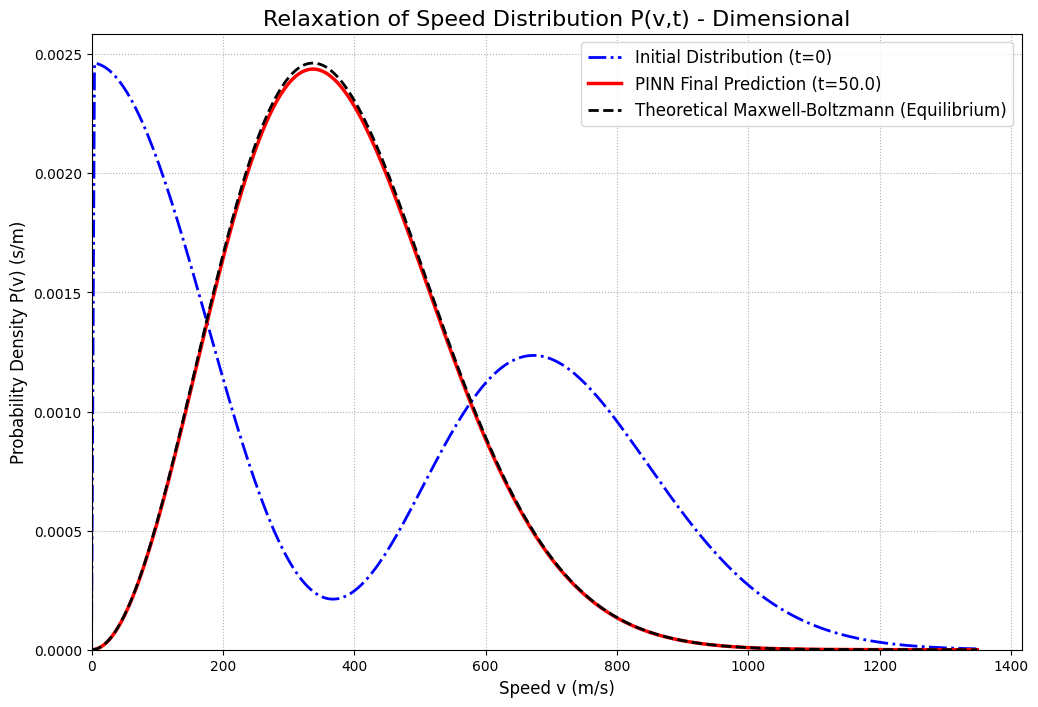

In [4]:
# -*- coding: utf-8 -*-
"""
کد نهایی برای حل مسئله رهایش با PINN

--- نسخه نهایی با رویکرد یادگیری انحراف از تعادل (Φ) برای حداکثر پایداری ---
--- اصلاح شده برای مقیاس‌بندی صحیح، رفع خطا و ذخیره نمودار در فایل ---
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
  except RuntimeError as e:
    print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترها ---
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

# سرعت مشخصه (محتمل‌ترین سرعت در توزیع ماکسول-بولتزمن)
V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS

print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 4.0
ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 50.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """
    تابع توزیع سرعت ماکسول-بولتزمن بی‌بعد شده.
    این تابع به گونه‌ای نرمال شده که انتگرال آن روی v_hat از ۰ تا بی‌نهایت برابر با ۱ شود.
    P_M_hat = (4/sqrt(pi)) * v_hat^2 * exp(-v_hat^2)
    """
    return (4 / np.sqrt(np.pi)) * v_hat**2 * tf.exp(-v_hat**2)

# --- تعریف PDE و IC بر حسب Φ ---
def pde_phi(x, Phi):
    # x = [t_hat, v_hat]
    # Phi = خروجی شبکه عصبی

    # معادله ساده شده برای انحراف از تعادل: d(Phi)/dt = -w(t) * Phi
    dPhi_dt_hat = dde.grad.jacobian(Phi, x, i=0, j=0)

    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat) # ضریب رهایش که به تدریج فعال می‌شود

    return dPhi_dt_hat + w_that * Phi

@tf.function
def initial_phi(x):
    # Φ(t=0) = P_initial(v) / P_M(v) - 1
    v_hat = x[:, 1:2]

    # یک توزیع اولیه غیرتعادلی (دو قله‌ای) برای تست
    # برای نرمال‌سازی صحیح، از انتگرال‌گیری عددی (جمع ریمان) استفاده می‌کنیم
    v_space = tf.linspace(0., SPEED_MAX_NONDIM, 1000)
    term1_space = 0.5 * maxwell_boltzmann_nondim(v_space - 1.0)
    term2_space = 0.5 * maxwell_boltzmann_nondim(v_space + 1.0)

    # این روش با @tf.function کاملا سازگار است
    integral_val = tf.reduce_sum(term1_space + term2_space) * (v_space[1] - v_space[0])

    term1 = 0.5 * maxwell_boltzmann_nondim(v_hat - 1.0)
    term2 = 0.5 * maxwell_boltzmann_nondim(v_hat + 1.0)
    p_initial_hat = (term1 + term2) / integral_val

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    # برای جلوگیری از تقسیم بر صفر در v=0
    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))


# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    geom = dde.geometry.Interval(0, SPEED_MAX_NONDIM)
    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(
        geomtime,
        pde_phi,
        [ic],
        num_domain=20000,
        num_initial=4000,
        num_test=4000,
    )

    # شبکه عصبی Φ را یاد می‌گیرد
    net = dde.maps.FNN([2] + [60] * 5 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # تعریف تابع سازنده برای تابع زیان سفارشی شامل قید پایستگی
    def create_loss_factory(model_instance, num_integral_pts=4096):
        # نقاط ثابت برای انتگرال‌گیری مونت کارلو جهت پایداری
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))

        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            # قید پایستگی: ∫ P_M * Φ dv_hat = 0
            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)
            phi_hat_at_integral_points = model_instance.net(integral_anchors)

            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points

            # انتگرال‌گیری مونت کارلو
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume
            conservation_loss = tf.square(integral_value)

            return original_loss + conservation_loss * CONSERVATION_LOSS_WEIGHT

        return loss_func

    final_loss_fn = create_loss_factory(model)
    model.compile("adam", lr=1e-3, loss=final_loss_fn)

    print("شروع آموزش با Adam...")
    losshistory, train_state = model.train(epochs=40000, display_every=2000)

    print("\nشروع آموزش با L-BFGS...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory, train_state = model.train()

    # --- افزایش اندازه فونت برای رسم نمودار ---
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'axes.titlesize': 18
    })

    print("\nرسم و ذخیره‌سازی نتایج...")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 300).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    x_final_hat = np.hstack((t_hat_final, v_hat_plot))

    # پیش‌بینی Φ و ساخت P_hat
    phi_final_hat_pred = model.predict(x_final_hat)
    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    # بازگرداندن ابعاد برای رسم نمودار
    # v = v_hat * V_CHAR
    # P(v) = P_hat(v_hat) / V_CHAR

    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label='PINN Final Distribution (t -> inf)')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t) - Dimensional')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))

    # --- خط جدید برای ذخیره نمودار ---
    # این دستور نمودار را با نام 'relaxation_pinn_result.jpg' ذخیره می‌کند.
    # dpi=300 کیفیت تصویر را بالا می‌برد.
    # bbox_inches='tight' حاشیه‌های سفید اضافی را حذف می‌کند.
    plt.savefig('relaxation_pinn_result.jpg', dpi=300, bbox_inches='tight')

    # نمایش نمودار در خروجی
    plt.show()

    print("\nنمودار با موفقیت در فایل 'relaxation_pinn_result.jpg' ذخیره شد.")

In [2]:
pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.3 MB/s eta 0:00:00


1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Set the default float type to float32
Compiling model...
'compile' took 0.007071 s

شروع آموزش با Adam...
Training model...

Step      Train loss              Test loss               Test metric
0         [3.92e-02, 1.80e-02]    [4.35e-02, 1.80e-02]    []  
2000      [2.18e-06, 3.24e-07]    [2.31e-06, 3.08e-07]    []  
4000      [8.63e-06, 9.96e-07]    [1.02e-05, 9.95e-07]    []  
6000      [1.13e-07, 7.67e-09]    [1.24e-07, 1.00e-08]    []  
8000      [1.79e-07, 3.17e-08]    [1.89e-07, 3.15e-08]    []  
10000     [3.99e-08, 4.03e-09]    [4.27e-08, 4.59e-09]    []  
12000     [1.18e-07, 8.18e-09]    [1.18e-07, 8.18e-09]    []  
14000     [2.50e-08, 4.64e-09]    [2.18e-08, 4.67e-09]    []  
16000     [1.02e-08, 1.58e-09]    [1.15e-08, 1.53e-09]    []  
18000     [2.91e-08, 1.19e-09]    [3.39e-08, 1.23e-09]    []  
20000     [8.75e-08, 6.42e-09]    [7.64e-08, 6.69e-09]    []  
22000     [1.46e-08, 2.63e-09]    [1.0

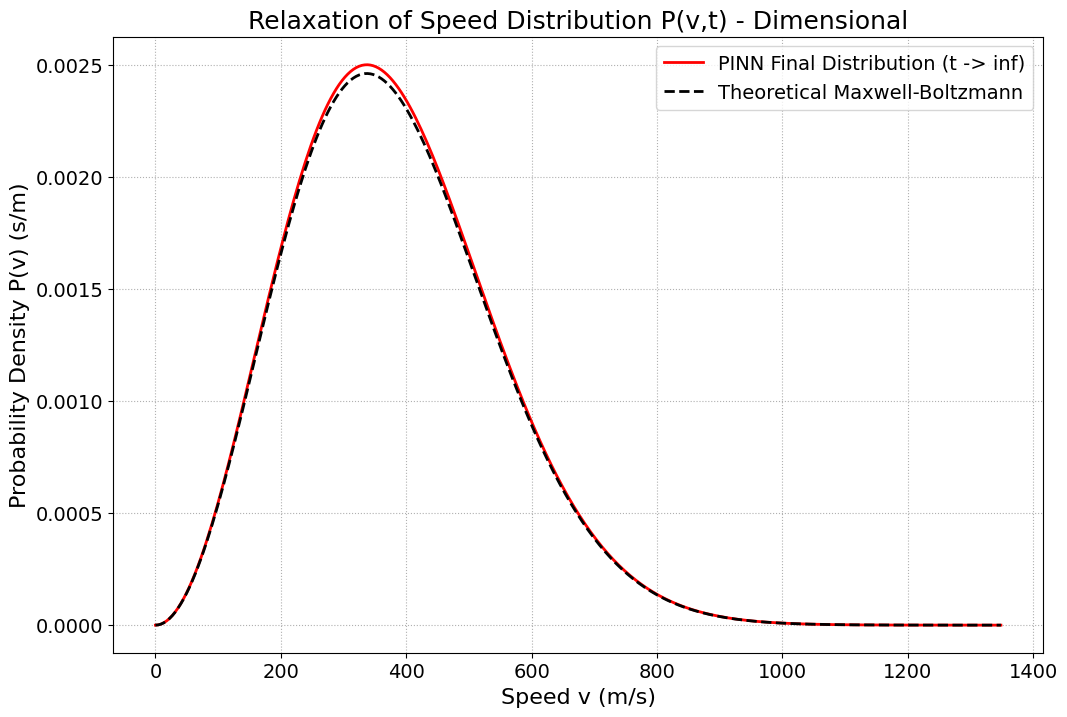


نمودار تابع توزیع با موفقیت در فایل 'relaxation_pinn_result.jpg' ذخیره شد.

رسم و ذخیره‌سازی نمودار همگرایی...


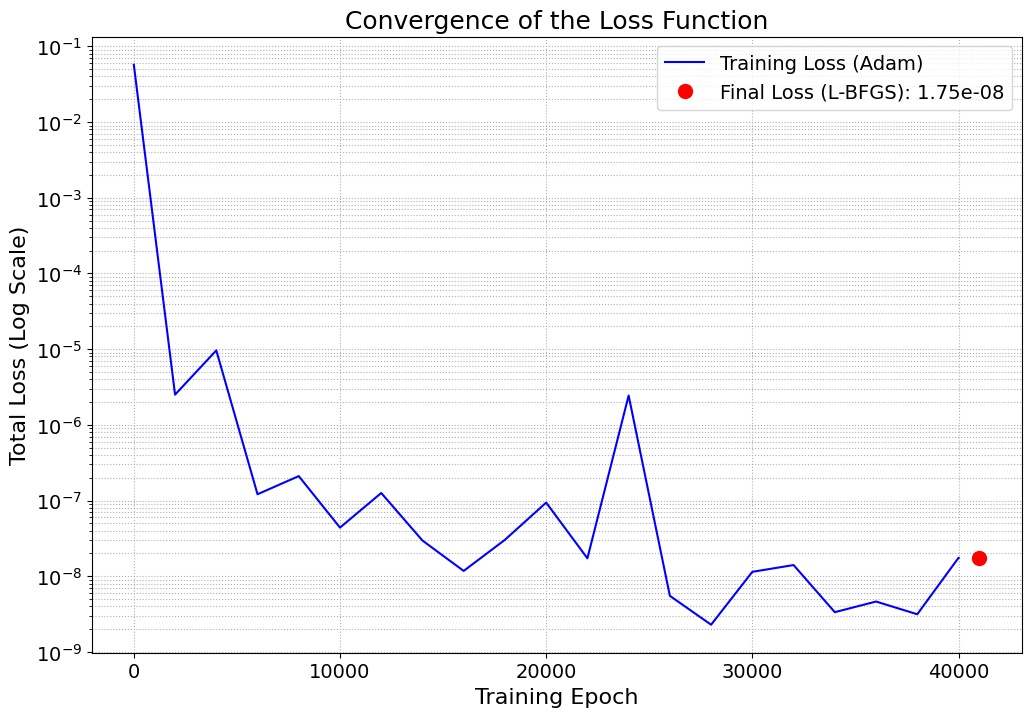


نمودار همگرایی با موفقیت در فایل 'loss_convergence.jpg' ذخیره شد.


In [18]:
# -*- coding: utf-8 -*-
"""
کد نهایی برای حل مسئله رهایش با PINN

--- نسخه نهایی با رویکرد یادگیری انحراف از تعادل (Φ) برای حداکثر پایداری ---
--- اصلاح شده برای مقیاس‌بندی صحیح، رفع خطا و ذخیره نمودار در فایل ---
--- افزوده شدن نمودار همگرایی شبکه ---
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترها ---
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

# سرعت مشخصه (محتمل‌ترین سرعت در توزیع ماکسول-بولتزمن)
V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS

print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 4.0
ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 50.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """
    تابع توزیع سرعت ماکسول-بولتزمن بی‌بعد شده.
    این تابع به گونه‌ای نرمال شده که انتگرال آن روی v_hat از ۰ تا بی‌نهایت برابر با ۱ شود.
    P_M_hat = (4/sqrt(pi)) * v_hat^2 * exp(-v_hat^2)
    """
    return (4 / np.sqrt(np.pi)) * v_hat**2 * tf.exp(-v_hat**2)

# --- تعریف PDE و IC بر حسب Φ ---
def pde_phi(x, Phi):
    # x = [t_hat, v_hat]
    # Phi = خروجی شبکه عصبی

    # معادله ساده شده برای انحراف از تعادل: d(Phi)/dt = -w(t) * Phi
    dPhi_dt_hat = dde.grad.jacobian(Phi, x, i=0, j=0)

    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat) # ضریب رهایش که به تدریج فعال می‌شود

    return dPhi_dt_hat + w_that * Phi

@tf.function
def initial_phi(x):
    # Φ(t=0) = P_initial(v) / P_M(v) - 1
    v_hat = x[:, 1:2]

    # یک توزیع اولیه غیرتعادلی (دو قله‌ای) برای تست
    # برای نرمال‌سازی صحیح، از انتگرال‌گیری عددی (جمع ریمان) استفاده می‌کنیم
    v_space = tf.linspace(0., SPEED_MAX_NONDIM, 1000)
    term1_space = 0.5 * maxwell_boltzmann_nondim(v_space - 1.0)
    term2_space = 0.5 * maxwell_boltzmann_nondim(v_space + 1.0)

    # این روش با @tf.function کاملا سازگار است
    integral_val = tf.reduce_sum(term1_space + term2_space) * (v_space[1] - v_space[0])

    term1 = 0.5 * maxwell_boltzmann_nondim(v_hat - 1.0)
    term2 = 0.5 * maxwell_boltzmann_nondim(v_hat + 1.0)
    p_initial_hat = (term1 + term2) / integral_val

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    # برای جلوگیری از تقسیم بر صفر در v=0
    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))


# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    geom = dde.geometry.Interval(0, SPEED_MAX_NONDIM)
    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(
        geomtime,
        pde_phi,
        [ic],
        num_domain=20000,
        num_initial=4000,
        num_test=4000,
    )

    # شبکه عصبی Φ را یاد می‌گیرد
    net = dde.maps.FNN([2] + [60] * 5 + [1], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # تعریف تابع سازنده برای تابع زیان سفارشی شامل قید پایستگی
    def create_loss_factory(model_instance, num_integral_pts=4096):
        # نقاط ثابت برای انتگرال‌گیری مونت کارلو جهت پایداری
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))

        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            # قید پایستگی: ∫ P_M * Φ dv_hat = 0
            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)
            phi_hat_at_integral_points = model_instance.net(integral_anchors)

            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points

            # انتگرال‌گیری مونت کارلو
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume
            conservation_loss = tf.square(integral_value)

            return original_loss + conservation_loss * CONSERVATION_LOSS_WEIGHT

        return loss_func

    final_loss_fn = create_loss_factory(model)
    model.compile("adam", lr=1e-3, loss=final_loss_fn)

    print("شروع آموزش با Adam...")
    losshistory_adam, train_state_adam = model.train(epochs=40000, display_every=2000)

    print("\nشروع آموزش با L-BFGS...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- افزایش اندازه فونت برای تمام نمودارها ---
    plt.rcParams.update({
        'font.size': 14,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14,
        'axes.titlesize': 18
    })

    # --- ۴. رسم و ذخیره نمودار تابع توزیع نهایی ---
    print("\nرسم و ذخیره‌سازی نتایج تابع توزیع...")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 300).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    x_final_hat = np.hstack((t_hat_final, v_hat_plot))

    # پیش‌بینی Φ و ساخت P_hat
    phi_final_hat_pred = model.predict(x_final_hat)
    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    # بازگرداندن ابعاد برای رسم نمودار
    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label='PINN Final Distribution (t -> inf)')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t) - Dimensional')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))

    plt.savefig('relaxation_pinn_result.jpg', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nنمودار تابع توزیع با موفقیت در فایل 'relaxation_pinn_result.jpg' ذخیره شد.")

    # --- ۵. رسم و ذخیره نمودار همگرایی تابع زیان ---
    print("\nرسم و ذخیره‌سازی نمودار همگرایی...")

    plt.figure(figsize=(12, 8))

    # استخراج تاریخچه زیان از آموزش Adam
    epochs_adam = losshistory_adam.steps
    loss_adam = np.sum(losshistory_adam.loss_train, axis=1)

    plt.semilogy(epochs_adam, loss_adam, 'b-', label='Training Loss (Adam)')

    # اضافه کردن یک نقطه برای نشان دادن زیان نهایی پس از L-BFGS
    # این کار تاثیر بهینه‌ساز ثانویه را به خوبی نمایش می‌دهد
    if losshistory_lbfgs.loss_train:
        final_loss_lbfgs = np.sum(losshistory_lbfgs.loss_train[-1])
        # یک آفست کوچک به محور x می‌دهیم تا نقطه در نمودار مشخص باشد
        final_epoch_point = epochs_adam[-1] + 1000
        plt.semilogy(final_epoch_point, final_loss_lbfgs, 'ro', markersize=10, label=f'Final Loss (L-BFGS): {final_loss_lbfgs:.2e}')

    plt.title('Convergence of the Loss Function')
    plt.xlabel('Training Epoch')
    plt.ylabel('Total Loss (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", linestyle=':')

    plt.savefig('loss_convergence.jpg', dpi=300, bbox_inches='tight')
    plt.show()

    print("\nنمودار همگرایی با موفقیت در فایل 'loss_convergence.jpg' ذخیره شد.")

1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Set the default float type to float32
Compiling model...
'compile' took 0.000479 s

Starting Adam training...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.62e+01, 2.66e+01]    [2.62e+01, 2.66e+01]    []  
2000      [1.32e-06, 4.25e-07]    [1.14e-06, 4.25e-07]    []  
4000      [8.56e-07, 7.06e-08]    [6.09e-07, 7.06e-08]    []  
6000      [4.80e-07, 1.36e-07]    [3.71e-07, 1.36e-07]    []  
8000      [6.48e-07, 6.36e-08]    [5.79e-07, 6.36e-08]    []  
10000     [6.83e-07, 2.17e-08]    [6.30e-07, 2.17e-08]    []  
12000     [1.81e-04, 1.73e-04]    [1.87e-04, 1.73e-04]    []  
14000     [1.17e-07, 5.41e-09]    [1.03e-07, 5.41e-09]    []  
16000     [3.70e-05, 1.14e-04]    [3.26e-05, 1.14e-04]    []  
18000     [1.93e-07, 1.29e-09]    [1.75e-07, 1.29e-09]    []  
20000     [5.06e-08, 1.18e-09]    [4.49e-08, 1.18e-09]    []  
22000     [3.06e-07, 6.28e-10]    

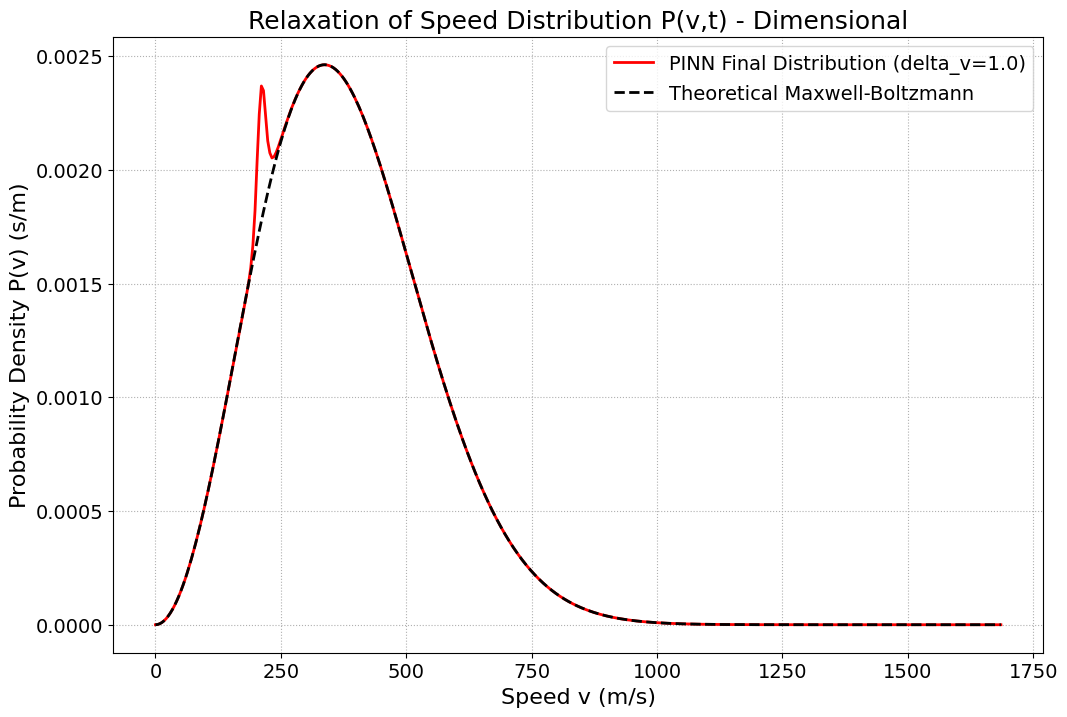

Distribution plot saved successfully to 'relaxation_pinn_generalized_result.eps'


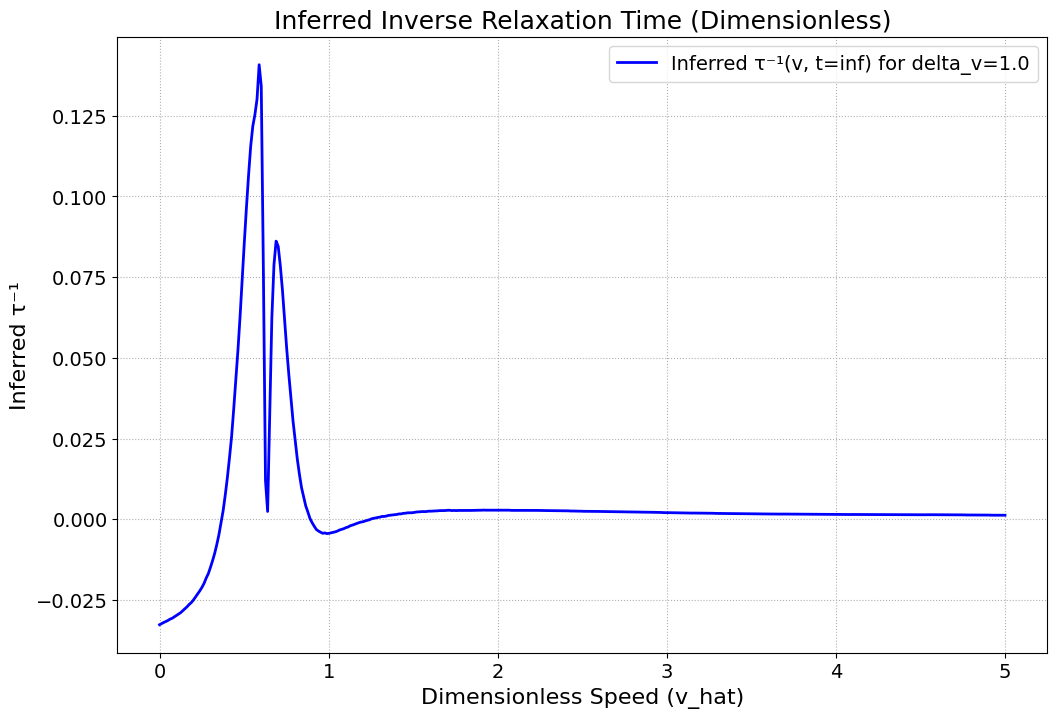

Inferred relaxation time plot saved successfully to 'inferred_relaxation_time.eps'

Plotting and saving convergence history...


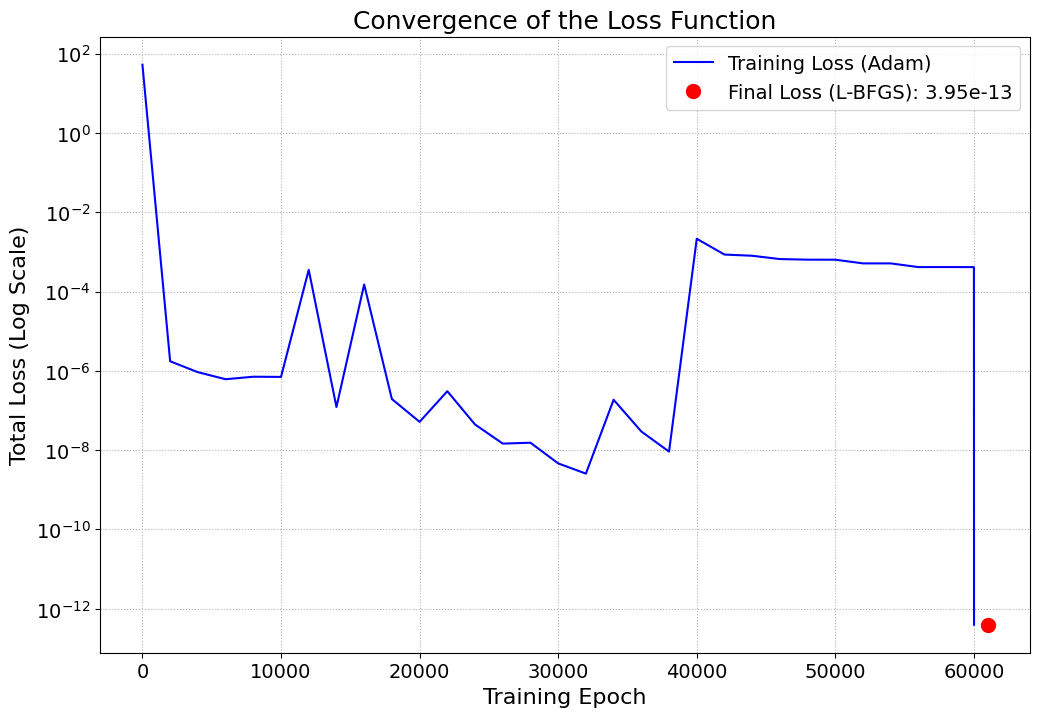

Loss convergence plot saved successfully to 'loss_convergence_generalized.eps'


In [22]:
# -*- coding: utf-8 -*-
"""
کد نهایی و عمومی‌شده برای حل مسئله رهایش با PINN (نسخه اصلاح شده)

--- نسخه عمومی‌شده با رویکردهای پیشرفته ---
۱. یادگیری همزمان خانواده‌ای از شرایط اولیه با پارامتر شرطی (delta_v)
۲. استنتاج دینامیک نرخ واهلش (τ⁻¹) به عنوان خروجی کمکی شبکه
۳. ذخیره نمودارها با فرمت برداری EPS برای حداکثر کیفیت
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترهای عمومی ---
# پارامترهای فیزیکی
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

# مقادیر مشخصه برای بی‌بعدسازی
V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS
print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

# پارامترهای دامنه محاسباتی
TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 5.0

# **تغییر کلیدی (تصویر ۲):** تعریف دامنه برای پارامتر شرطی اولیه
# این پارامتر (delta_v) میزان جدایی در توزیع اولیه دو قله‌ای را کنترل می‌کند.
DELTA_V_MIN_NONDIM = 0.5
DELTA_V_MAX_NONDIM = 1.5

# پارامترهای مدل
ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 10.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """توزیع سرعت ماکسول-بولتزمن بی‌بعد شده."""
    return (4 / np.sqrt(np.pi)) * v_hat**2 * tf.exp(-v_hat**2)

# **تغییر کلیدی (تصویر ۱ و ۲):** تعریف PDE برای مدل جدید
def pde(x, y):
    """
    معادله دیفرانسیل حاکم بر مسئله.
    x: ورودی شبکه (t, v, delta_v)
    y: خروجی شبکه (Phi, tau_inv)
    """
    # تفکیک خروجی‌های شبکه
    Phi = y[:, 0:1]
    tau_inv = y[:, 1:2]  # tau_inv مستقیماً از شبکه می‌آید

    # محاسبه مشتق Phi نسبت به زمان
    dPhi_dt_hat = dde.grad.jacobian(y, x, i=0, j=0) # مشتق خروجی اول (Phi) نسبت به ورودی اول (t)

    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat)

    # باقیمانده PDE: dΦ/dt + w(t) * τ⁻¹ * Φ = 0
    # در اینجا، τ⁻¹ یک تابع یادگرفتنی است نه یک مقدار ثابت.
    return dPhi_dt_hat + w_that * tau_inv * Phi

# **تغییر کلیدی (تصویر ۲):** تعریف شرط اولیه پارامتری
@tf.function
def initial_phi(x):
    """
    شرط اولیه برای انحراف از تعادل (Φ).
    این تابع یک خانواده از شرایط اولیه را بر اساس پارامتر delta_v تولید می‌کند.
    """
    v_hat = x[:, 1:2]
    delta_v_hat = x[:, 2:3] # پارامتر شرطی از ورودی گرفته می‌شود

    # تعریف توزیع اولیه دو قله‌ای (bimodal) که با delta_v_hat پارامتری شده
    p_initial_hat = 0.5 * maxwell_boltzmann_nondim(v_hat - delta_v_hat) + \
                    0.5 * maxwell_boltzmann_nondim(v_hat + delta_v_hat)

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    # محاسبه Φ(v, t=0) = P_initial(v) / P_maxwell(v) - 1
    # از یک مقدار کوچک (epsilon) برای جلوگیری از تقسیم بر صفر استفاده می‌شود.
    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))

# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    # **تغییر کلیدی (تصویر ۲):** تعریف دامنه سه‌بعدی (t, v, delta_v)
    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)

    # --- اصلاحیه برای رفع خطا ---
    # به جای CompositeDomain از Hypercube برای تعریف دامنه فضایی چندبعدی استفاده می‌کنیم.
    # دامنه فضایی ما اکنون ۲ بعدی است: (v, delta_v)
    spatial_domain_min = [0, DELTA_V_MIN_NONDIM]
    spatial_domain_max = [SPEED_MAX_NONDIM, DELTA_V_MAX_NONDIM]
    space_domain = dde.geometry.Hypercube(spatial_domain_min, spatial_domain_max)
    # --- پایان اصلاحیه ---

    geomtime = dde.geometry.GeometryXTime(space_domain, timedomain)

    # تعریف شرط اولیه برای دامنه جدید
    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    # تعریف داده‌های آموزشی برای PDE
    data = dde.data.TimePDE(
        geomtime,
        pde,
        [ic],
        num_domain=80000,   # افزایش تعداد نقاط به دلیل افزایش ابعاد
        num_initial=10000,
        num_test=20000,
    )

    # **تغییر کلیدی (تصویر ۱ و ۲):** تعریف ساختار شبکه جدید
    # ورودی ۳ بعدی (t, v, delta_v) و خروجی ۲ بعدی (Phi, tau_inv)
    # افزایش عمق و عرض شبکه برای یادگیری مسئله پیچیده‌تر
    net = dde.maps.FNN([3] + [80] * 6 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    # تعریف تابع زیان سفارشی با قید پایستگی (تطبیق داده شده برای مدل جدید)
    def create_loss_factory(model_instance, num_integral_pts=8192):
        # نقاط انتگرال‌گیری در دامنه سه‌بعدی نمونه‌برداری می‌شوند
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))
        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            # استخراج Phi از خروجی شبکه برای محاسبه انتگرال
            network_output = model_instance.net(integral_anchors)
            phi_hat_at_integral_points = network_output[:, 0:1]

            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)

            # انتگرال باید روی بعد سرعت (v) گرفته شود
            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points
            domain_volume = SPEED_MAX_NONDIM # حجم دامنه سرعت
            integral_value = tf.reduce_mean(integrand) * domain_volume # میانگین‌گیری روی همه نقاط نمونه‌برداری شده

            conservation_loss = tf.square(integral_value)
            return original_loss + CONSERVATION_LOSS_WEIGHT * conservation_loss
        return loss_func

    final_loss_fn = create_loss_factory(model)

    # تنظیمات بهینه‌ساز
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.9, staircase=True
    )
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate_schedule, clipnorm=1.0
    )

    model.compile(adam_optimizer, loss=final_loss_fn)

    print("Starting Adam training...")
    losshistory_adam, train_state_adam = model.train(epochs=60000, display_every=2000) # افزایش اپوک‌ها

    print("\nStarting L-BFGS training...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- ۴. مصورسازی و ذخیره نتایج ---
    plt.rcParams.update({
        'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14,
        'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18
    })

    # انتخاب یک مقدار خاص برای delta_v برای رسم نمودار
    delta_v_plot_val = 1.0
    print(f"\nPlotting results for a specific case: delta_v = {delta_v_plot_val}")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 400).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    delta_v_hat_plot = np.ones_like(v_hat_plot) * delta_v_plot_val

    # ساخت ورودی سه‌بعدی برای پیش‌بینی
    x_final_hat = np.hstack((t_hat_final, v_hat_plot, delta_v_hat_plot))

    # پیش‌بینی با مدل آموزش‌دیده
    prediction = model.predict(x_final_hat)
    phi_final_hat_pred = prediction[:, 0:1]
    tau_inv_final_hat_pred = prediction[:, 1:2] # استخراج خروجی دوم

    # بازسازی تابع توزیع نهایی
    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    # تبدیل به ابعاد فیزیکی
    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    # رسم نمودار تابع توزیع نهایی
    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label=f'PINN Final Distribution (delta_v={delta_v_plot_val})')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t) - Dimensional')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))
    plt.savefig('relaxation_pinn_generalized_result.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Distribution plot saved successfully to 'relaxation_pinn_generalized_result.eps'")

    # **نمودار جدید (تصویر ۱):** رسم تابع معکوس زمان واهلش یادگرفته‌شده
    plt.figure(figsize=(12, 8))
    plt.plot(v_hat_plot, tau_inv_final_hat_pred, 'b-', linewidth=2, label=f'Inferred τ⁻¹(v, t=inf) for delta_v={delta_v_plot_val}')
    plt.title('Inferred Inverse Relaxation Time (Dimensionless)')
    plt.xlabel('Dimensionless Speed (v_hat)')
    plt.ylabel('Inferred τ⁻¹')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.savefig('inferred_relaxation_time.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Inferred relaxation time plot saved successfully to 'inferred_relaxation_time.eps'")

    # رسم و ذخیره نمودار همگرایی تابع زیان
    print("\nPlotting and saving convergence history...")
    plt.figure(figsize=(12, 8))
    epochs_adam = losshistory_adam.steps
    loss_adam = np.sum(losshistory_adam.loss_train, axis=1)
    plt.semilogy(epochs_adam, loss_adam, 'b-', label='Training Loss (Adam)')
    if losshistory_lbfgs.loss_train:
        final_loss_lbfgs = np.sum(losshistory_lbfgs.loss_train[-1])
        final_epoch_point = epochs_adam[-1] + 1000
        plt.semilogy(final_epoch_point, final_loss_lbfgs, 'ro', markersize=10, label=f'Final Loss (L-BFGS): {final_loss_lbfgs:.2e}')
    plt.title('Convergence of the Loss Function')
    plt.xlabel('Training Epoch')
    plt.ylabel('Total Loss (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", linestyle=':')
    plt.savefig('loss_convergence_generalized.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Loss convergence plot saved successfully to 'loss_convergence_generalized.eps'")

1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Set the default float type to float32
Compiling model...
'compile' took 0.000506 s

Starting Adam training...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.55e+01, 2.58e+01]    [2.55e+01, 2.58e+01]    []  
2000      [5.31e-06, 4.14e-06]    [5.05e-06, 4.14e-06]    []  
4000      [4.51e-06, 4.24e-06]    [4.38e-06, 4.24e-06]    []  
6000      [6.32e-07, 3.21e-08]    [5.05e-07, 3.21e-08]    []  
8000      [4.54e-05, 2.46e-06]    [4.72e-05, 2.46e-06]    []  
10000     [7.79e-07, 3.98e-08]    [6.71e-07, 3.98e-08]    []  
12000     [7.39e-07, 1.69e-08]    [6.57e-07, 1.69e-08]    []  
14000     [1.28e-07, 5.08e-09]    [1.07e-07, 5.08e-09]    []  
16000     [4.81e-07, 2.80e-09]    [4.46e-07, 2.80e-09]    []  
18000     [9.18e-08, 2.23e-09]    [7.61e-08, 2.23e-09]    []  
20000     [5.36e-07, 8.25e-06]    [5.35e-07, 8.25e-06]    []  
22000     [2.63e-07, 2.34e-10]    

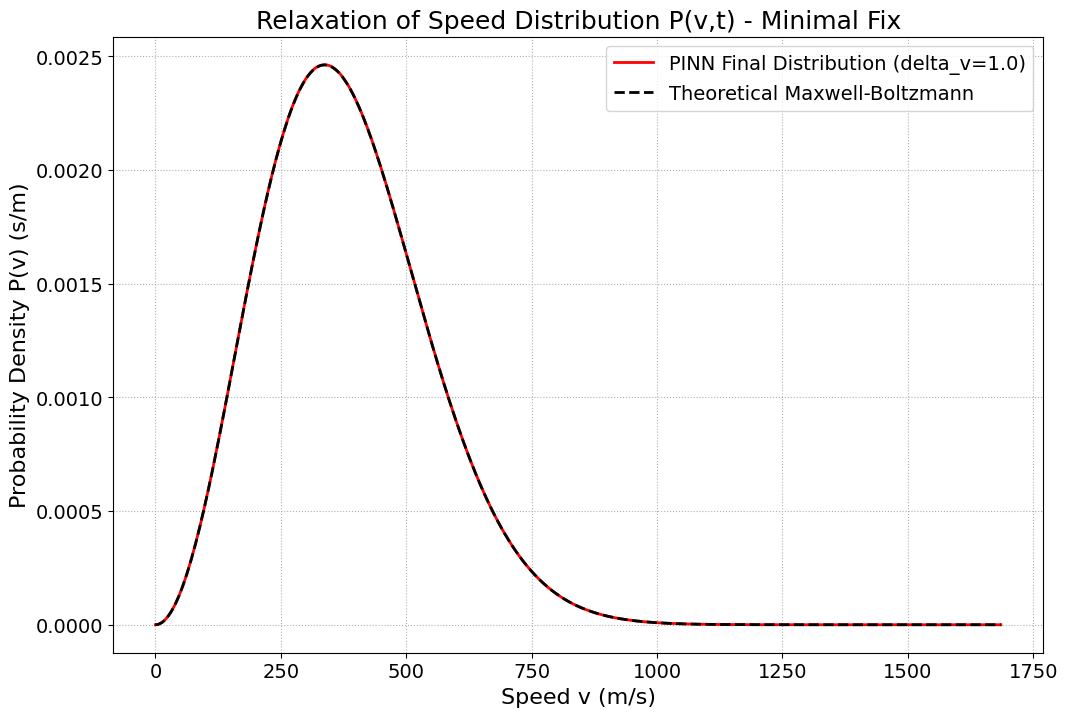

Distribution plot saved successfully.


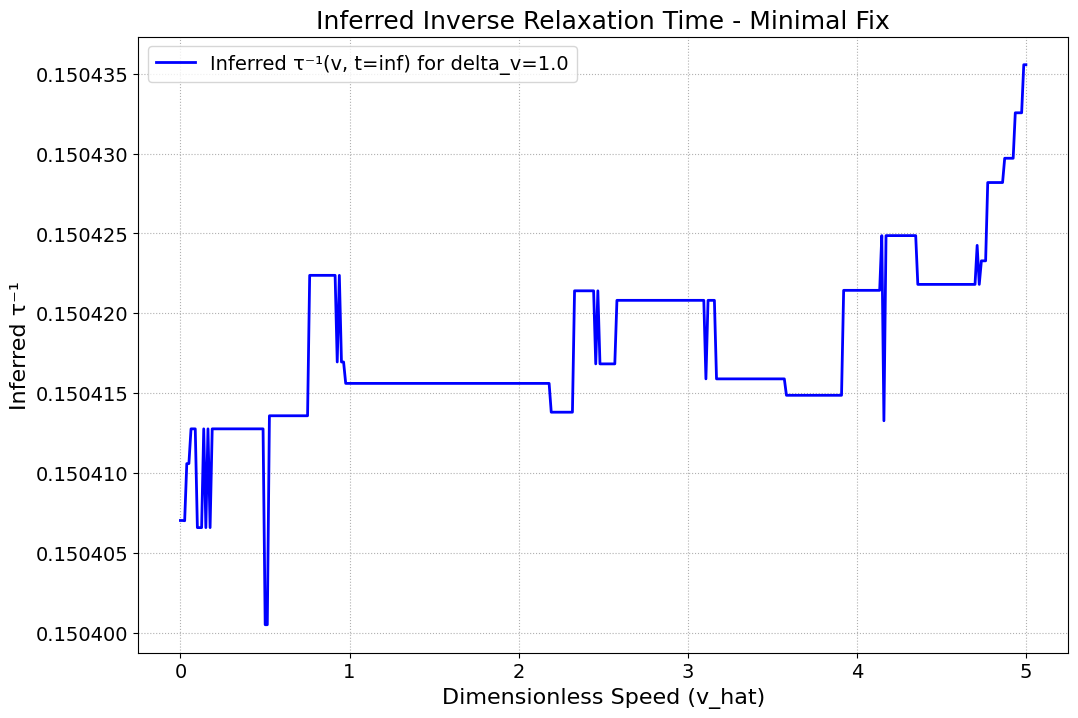

Inferred relaxation time plot saved successfully.
Saving loss history to ./loss.dat ...
Saving training data to ./train.dat ...
Saving test data to ./test.dat ...


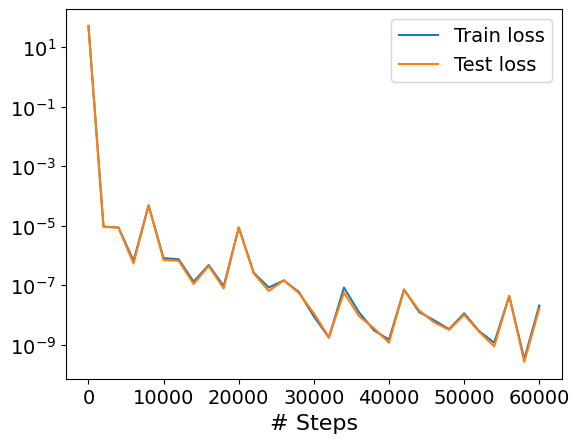

In [27]:
# -*- coding: utf-8 -*-
"""
کد اولیه عمومی‌شده با یک بهبود جزئی برای پایداری

--- تغییر کلیدی در این نسخه ---
۱. فقط یک خط کد در تابع pde تغییر کرده است.
۲. با استفاده از تابع softplus تضمین می‌شود که خروجی دوم شبکه (τ⁻¹) همیشه مثبت باشد.
   این کار از غیرفیزیکی شدن جواب جلوگیری کرده و به پایداری آموزش کمک می‌کند.
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترهای عمومی ---
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS
print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 5.0

DELTA_V_MIN_NONDIM = 0.5
DELTA_V_MAX_NONDIM = 1.5

ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 10.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """توزیع سرعت ماکسول-بولتزمن بی‌بعد شده."""
    # افزودن یک مقدار بسیار کوچک برای پایداری کامل در v=0
    return (4 / np.sqrt(np.pi)) * (v_hat**2 + 1e-8) * tf.exp(-v_hat**2)

def pde(x, y):
    """
    معادله دیفرانسیل حاکم بر مسئله.
    """
    Phi = y[:, 0:1]

    # --- *** تنها تغییر کلیدی در اینجا اعمال شده است *** ---
    # خروجی خام شبکه برای tau_inv
    tau_inv_raw = y[:, 1:2]
    # استفاده از softplus برای تضمین اینکه tau_inv همیشه مثبت باشد
    tau_inv = tf.nn.softplus(tau_inv_raw)
    # --- *** پایان تغییر *** ---

    dPhi_dt_hat = dde.grad.jacobian(y, x, i=0, j=0)
    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat)

    return dPhi_dt_hat + w_that * tau_inv * Phi

@tf.function
def initial_phi(x):
    """
    شرط اولیه برای انحراف از تعادل (Φ).
    """
    v_hat = x[:, 1:2]
    delta_v_hat = x[:, 2:3]

    p_initial_hat = 0.5 * maxwell_boltzmann_nondim(v_hat - delta_v_hat) + \
                    0.5 * maxwell_boltzmann_nondim(v_hat + delta_v_hat)

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))

# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    spatial_domain_min = [0, DELTA_V_MIN_NONDIM]
    spatial_domain_max = [SPEED_MAX_NONDIM, DELTA_V_MAX_NONDIM]
    space_domain = dde.geometry.Hypercube(spatial_domain_min, spatial_domain_max)
    geomtime = dde.geometry.GeometryXTime(space_domain, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(
        geomtime,
        pde,
        [ic],
        num_domain=80000,
        num_initial=10000,
        num_test=20000,
    )

    net = dde.maps.FNN([3] + [80] * 6 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    def create_loss_factory(model_instance, num_integral_pts=8192):
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))
        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            network_output = model_instance.net(integral_anchors)
            phi_hat_at_integral_points = network_output[:, 0:1]

            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)

            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume

            conservation_loss = tf.square(integral_value)
            return original_loss + CONSERVATION_LOSS_WEIGHT * conservation_loss
        return loss_func

    final_loss_fn = create_loss_factory(model)

    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.9, staircase=True
    )
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate_schedule, clipnorm=1.0
    )

    model.compile(adam_optimizer, loss=final_loss_fn)

    # استفاده از 'iterations' به جای 'epochs' برای سازگاری با نسخه‌های جدید
    print("Starting Adam training...")
    losshistory_adam, train_state_adam = model.train(iterations=60000, display_every=2000)

    print("\nStarting L-BFGS training...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- ۴. مصورسازی و ذخیره نتایج ---
    plt.rcParams.update({
        'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14,
        'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18
    })

    delta_v_plot_val = 1.0
    print(f"\nPlotting results for a specific case: delta_v = {delta_v_plot_val}")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 400).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    delta_v_hat_plot = np.ones_like(v_hat_plot) * delta_v_plot_val

    x_final_hat = np.hstack((t_hat_final, v_hat_plot, delta_v_hat_plot))

    prediction = model.predict(x_final_hat)
    phi_final_hat_pred = prediction[:, 0:1]

    # تبدیل خروجی خام tau_inv به مقدار فیزیکی برای رسم
    tau_inv_raw_final_pred = prediction[:, 1:2]
    tau_inv_final_pred = tf.nn.softplus(tf.constant(tau_inv_raw_final_pred, dtype=tf.float32)).numpy()

    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label=f'PINN Final Distribution (delta_v={delta_v_plot_val})')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t) - Minimal Fix')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))
    plt.savefig('relaxation_pinn_minimal_fix_result.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Distribution plot saved successfully.")

    plt.figure(figsize=(12, 8))
    plt.plot(v_hat_plot, tau_inv_final_pred, 'b-', linewidth=2, label=f'Inferred τ⁻¹(v, t=inf) for delta_v={delta_v_plot_val}')
    plt.title('Inferred Inverse Relaxation Time - Minimal Fix')
    plt.xlabel('Dimensionless Speed (v_hat)')
    plt.ylabel('Inferred τ⁻¹')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.savefig('inferred_relaxation_time_minimal_fix.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Inferred relaxation time plot saved successfully.")

    # رسم نمودار همگرایی
    dde.saveplot(losshistory_adam, train_state_adam, issave=True, isplot=True, output_dir='.')

1 Physical GPUs, 1 Logical GPUs
Characteristic Velocity (v_c): 337.11 m/s
Set the default float type to float32
Compiling model...
'compile' took 0.000524 s

Starting Adam training...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.60e+01, 2.63e+01]    [2.60e+01, 2.63e+01]    []  
2000      [3.97e-06, 2.90e-06]    [3.74e-06, 2.90e-06]    []  
4000      [2.74e-06, 1.24e-06]    [2.55e-06, 1.24e-06]    []  
6000      [3.52e-07, 2.56e-08]    [2.86e-07, 2.56e-08]    []  
8000      [5.68e-07, 4.48e-09]    [4.55e-07, 4.48e-09]    []  
10000     [8.81e-07, 1.74e-08]    [8.47e-07, 1.74e-08]    []  
12000     [3.87e-07, 1.14e-07]    [4.00e-07, 1.14e-07]    []  
14000     [4.60e-07, 2.72e-07]    [4.33e-07, 2.72e-07]    []  
16000     [1.09e-07, 6.07e-09]    [1.07e-07, 6.07e-09]    []  
18000     [6.28e-08, 1.11e-10]    [4.46e-08, 1.11e-10]    []  
20000     [1.14e-08, 5.70e-11]    [8.98e-09, 5.70e-11]    []  
22000     [1.68e-06, 3.62e-09]    

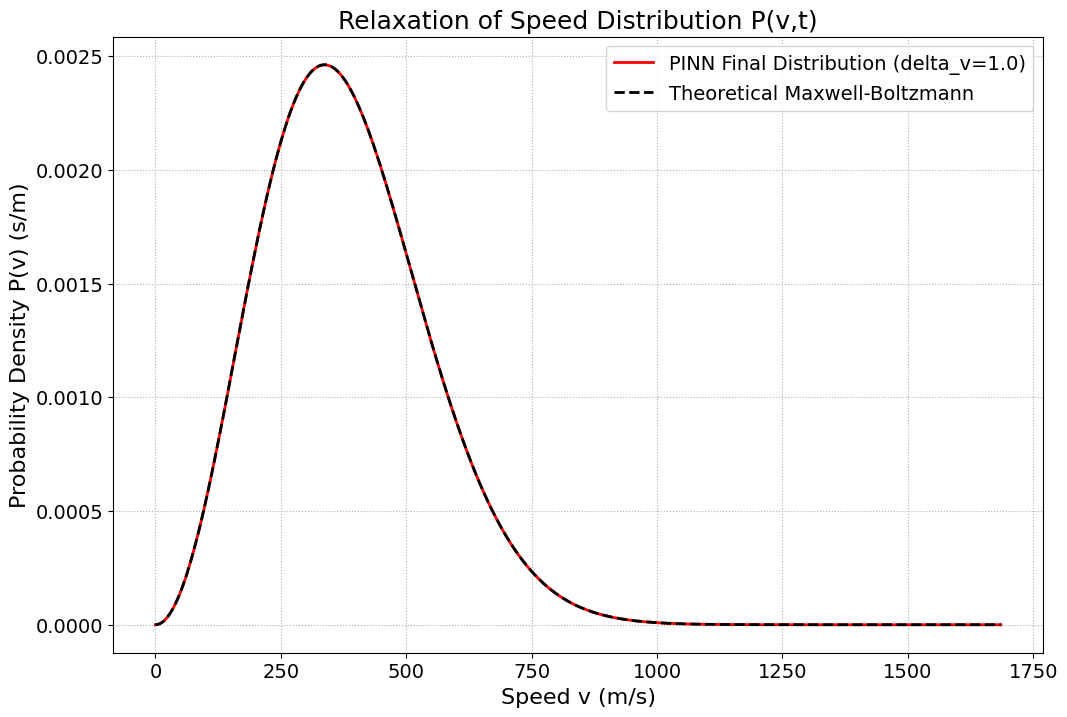

Distribution plot saved successfully to 'distribution_final.eps'


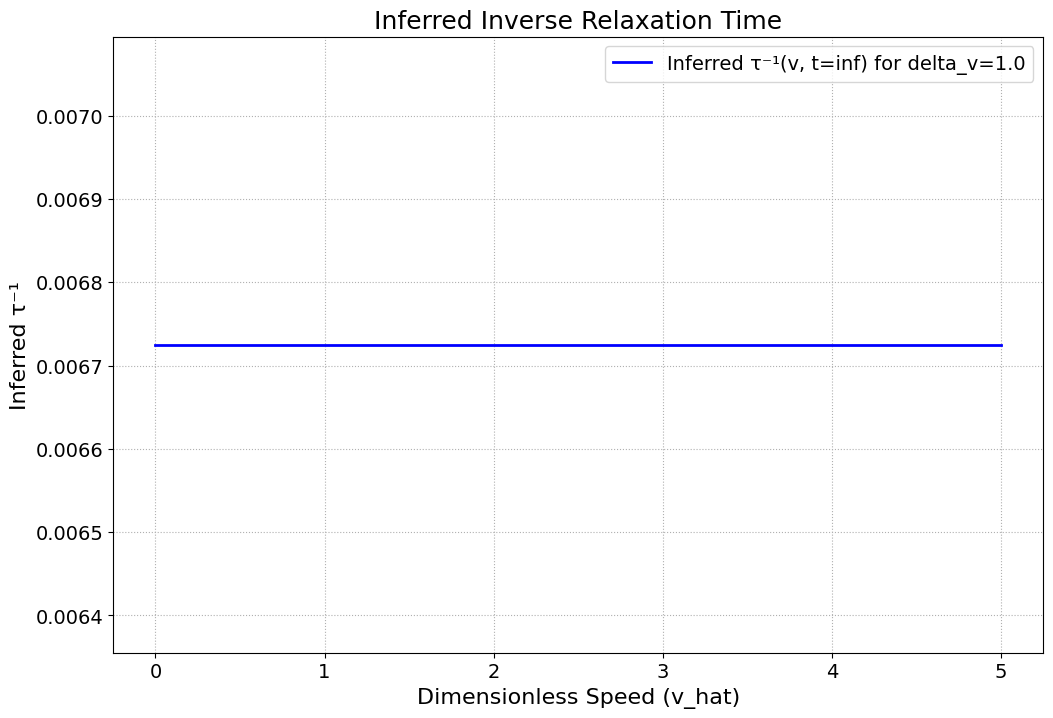

Inferred relaxation time plot saved successfully to 'relaxation_time_final.eps'


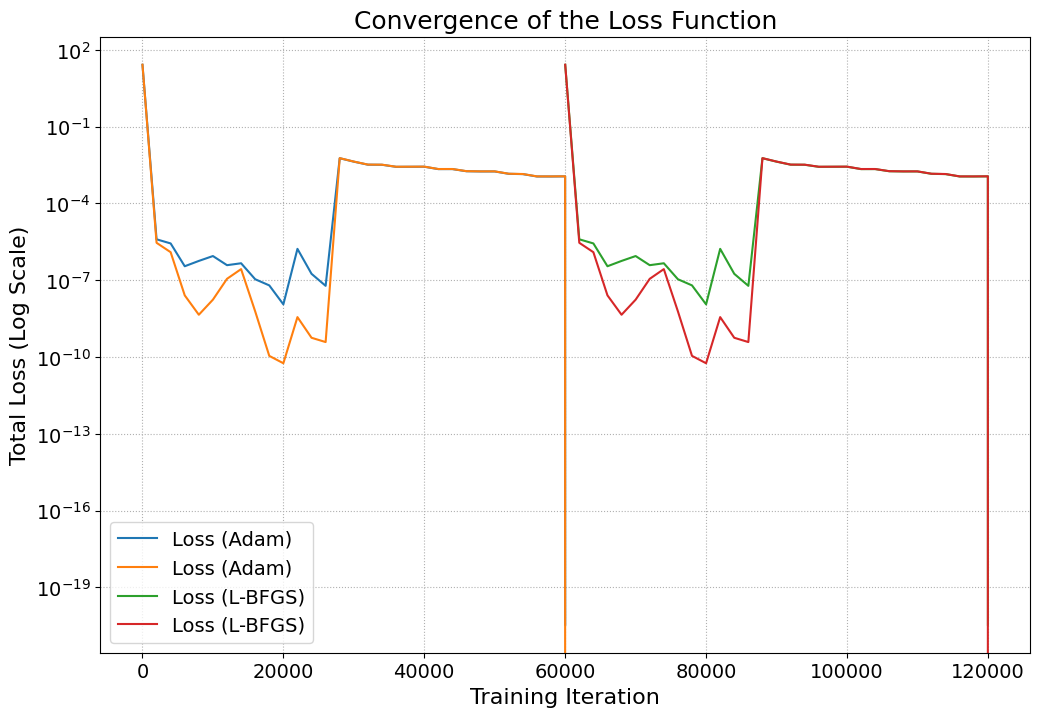

Loss convergence plot saved successfully to 'loss_convergence_final.eps'


In [28]:
# -*- coding: utf-8 -*-
"""
کد نهایی و پایدار شده برای حل مسئله واهلش

--- قابلیت‌ها ---
۱. حل مسئله برای خانواده‌ای از شرایط اولیه با پارامتر شرطی (delta_v).
۲. استنتاج دینامیک نرخ واهلش (τ⁻¹) به عنوان خروجی کمکی شبکه.
۳. تضمین پایداری با استفاده از تابع softplus برای مثبت نگه‌داشتن τ⁻¹.
۴. ذخیره تمام نمودارهای خروجی با فرمت برداری EPS برای حداکثر کیفیت.
"""
import os
os.environ['DDE_BACKEND'] = 'tensorflow'

import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

# --- مدیریت حافظه GPU ---
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} Physical GPUs, {len(tf.config.experimental.list_logical_devices('GPU'))} Logical GPUs")
    except RuntimeError as e:
        print(e)

# --- ۱. بخش بی‌بعدسازی و پارامترهای عمومی ---
T_EQ = 273.0
MASS_AR = 6.6335209e-26
KB = 1.380649e-23
N_DENSITY_EQ = 1.78 / MASS_AR
TAU_RELAXATION_PHYS = 1.0e-10

V_CHAR = np.sqrt(2 * KB * T_EQ / MASS_AR)
T_CHAR = TAU_RELAXATION_PHYS
print(f"Characteristic Velocity (v_c): {V_CHAR:.2f} m/s")

TIME_END_NONDIM = 50.0
SPEED_MAX_NONDIM = 5.0

DELTA_V_MIN_NONDIM = 0.5
DELTA_V_MAX_NONDIM = 1.5

ALPHA_LIMITER = 0.5
CONSERVATION_LOSS_WEIGHT = 10.0

# --- ۲. تعریف توابع بی‌بعد شده ---
@tf.function
def maxwell_boltzmann_nondim(v_hat):
    """توزیع سرعت ماکسول-بولتزمن بی‌بعد شده."""
    # افزودن یک مقدار بسیار کوچک برای پایداری کامل در v=0
    return (4 / np.sqrt(np.pi)) * (v_hat**2 + 1e-8) * tf.exp(-v_hat**2)

def pde(x, y):
    """
    معادله دیفرانسیل حاکم بر مسئله.
    """
    Phi = y[:, 0:1]

    # خروجی خام شبکه برای tau_inv
    tau_inv_raw = y[:, 1:2]
    # استفاده از softplus برای تضمین اینکه tau_inv همیشه مثبت باشد
    tau_inv = tf.nn.softplus(tau_inv_raw)

    dPhi_dt_hat = dde.grad.jacobian(y, x, i=0, j=0)
    t_hat = x[:, 0:1]
    w_that = tf.tanh(ALPHA_LIMITER * t_hat)

    return dPhi_dt_hat + w_that * tau_inv * Phi

@tf.function
def initial_phi(x):
    """
    شرط اولیه برای انحراف از تعادل (Φ).
    """
    v_hat = x[:, 1:2]
    delta_v_hat = x[:, 2:3]

    p_initial_hat = 0.5 * maxwell_boltzmann_nondim(v_hat - delta_v_hat) + \
                    0.5 * maxwell_boltzmann_nondim(v_hat + delta_v_hat)

    p_maxwell_hat = maxwell_boltzmann_nondim(v_hat)

    return tf.where(p_maxwell_hat > 1e-8, p_initial_hat / p_maxwell_hat - 1.0, tf.zeros_like(v_hat))

# --- ۳. راه‌اندازی و آموزش مدل ---
if __name__ == "__main__":
    dde.config.set_default_float("float32")
    tf.random.set_seed(2024)

    timedomain = dde.geometry.TimeDomain(0, TIME_END_NONDIM)
    spatial_domain_min = [0, DELTA_V_MIN_NONDIM]
    spatial_domain_max = [SPEED_MAX_NONDIM, DELTA_V_MAX_NONDIM]
    space_domain = dde.geometry.Hypercube(spatial_domain_min, spatial_domain_max)
    geomtime = dde.geometry.GeometryXTime(space_domain, timedomain)

    ic = dde.icbc.IC(geomtime, initial_phi, lambda _, on_initial: on_initial)

    data = dde.data.TimePDE(
        geomtime,
        pde,
        [ic],
        num_domain=80000,
        num_initial=10000,
        num_test=20000,
    )

    net = dde.maps.FNN([3] + [80] * 6 + [2], "tanh", "Glorot normal")
    model = dde.Model(data, net)

    def create_loss_factory(model_instance, num_integral_pts=8192):
        integral_anchors = tf.constant(geomtime.random_points(num_integral_pts), dtype=dde.config.real(tf))
        def loss_func(y_true, y_pred):
            original_loss = dde.losses.mean_squared_error(y_true, y_pred)

            network_output = model_instance.net(integral_anchors)
            phi_hat_at_integral_points = network_output[:, 0:1]

            v_hat_integral = integral_anchors[:, 1:2]
            p_m_hat_at_integral_points = maxwell_boltzmann_nondim(v_hat_integral)

            integrand = p_m_hat_at_integral_points * phi_hat_at_integral_points
            domain_volume = SPEED_MAX_NONDIM
            integral_value = tf.reduce_mean(integrand) * domain_volume

            conservation_loss = tf.square(integral_value)
            return original_loss + CONSERVATION_LOSS_WEIGHT * conservation_loss
        return loss_func

    final_loss_fn = create_loss_factory(model)

    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3, decay_steps=5000, decay_rate=0.9, staircase=True
    )
    adam_optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate_schedule, clipnorm=1.0
    )

    model.compile(adam_optimizer, loss=final_loss_fn)

    print("Starting Adam training...")
    losshistory_adam, train_state_adam = model.train(iterations=60000, display_every=2000)

    print("\nStarting L-BFGS training...")
    model.compile("L-BFGS", loss=final_loss_fn)
    losshistory_lbfgs, train_state_lbfgs = model.train()

    # --- ۴. مصورسازی و ذخیره نتایج ---
    plt.rcParams.update({
        'font.size': 14, 'axes.labelsize': 16, 'xtick.labelsize': 14,
        'ytick.labelsize': 14, 'legend.fontsize': 14, 'axes.titlesize': 18
    })

    delta_v_plot_val = 1.0
    print(f"\nPlotting results for a specific case: delta_v = {delta_v_plot_val}")

    v_hat_plot = np.linspace(0, SPEED_MAX_NONDIM, 400).reshape(-1, 1)
    t_hat_final = np.ones_like(v_hat_plot) * TIME_END_NONDIM
    delta_v_hat_plot = np.ones_like(v_hat_plot) * delta_v_plot_val

    x_final_hat = np.hstack((t_hat_final, v_hat_plot, delta_v_hat_plot))

    prediction = model.predict(x_final_hat)
    phi_final_hat_pred = prediction[:, 0:1]

    tau_inv_raw_final_pred = prediction[:, 1:2]
    tau_inv_final_pred = tf.nn.softplus(tf.constant(tau_inv_raw_final_pred, dtype=tf.float32)).numpy()

    p_m_hat_plot = maxwell_boltzmann_nondim(tf.constant(v_hat_plot, dtype=tf.float32)).numpy()
    p_final_hat_pred = p_m_hat_plot * (1 + phi_final_hat_pred)

    v_plot_dim = v_hat_plot * V_CHAR
    p_final_pred_dim = p_final_hat_pred / V_CHAR
    p_final_theory_dim = p_m_hat_plot / V_CHAR

    # ۱. نمودار تابع توزیع
    plt.figure(figsize=(12, 8))
    plt.plot(v_plot_dim, p_final_pred_dim, 'r-', linewidth=2, label=f'PINN Final Distribution (delta_v={delta_v_plot_val})')
    plt.plot(v_plot_dim, p_final_theory_dim, 'k--', linewidth=2, label='Theoretical Maxwell-Boltzmann')
    plt.title('Relaxation of Speed Distribution P(v,t)')
    plt.xlabel('Speed v (m/s)')
    plt.ylabel('Probability Density P(v) (s/m)')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.ylim(bottom=-0.05 * np.max(p_final_theory_dim))
    plt.savefig('distribution_final.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Distribution plot saved successfully to 'distribution_final.eps'")

    # ۲. نمودار زمان واهلش
    plt.figure(figsize=(12, 8))
    plt.plot(v_hat_plot, tau_inv_final_pred, 'b-', linewidth=2, label=f'Inferred τ⁻¹(v, t=inf) for delta_v={delta_v_plot_val}')
    plt.title('Inferred Inverse Relaxation Time')
    plt.xlabel('Dimensionless Speed (v_hat)')
    plt.ylabel('Inferred τ⁻¹')
    plt.legend()
    plt.grid(True, linestyle=':')
    plt.savefig('relaxation_time_final.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Inferred relaxation time plot saved successfully to 'relaxation_time_final.eps'")

    # ۳. نمودار همگرایی تابع زیان
    plt.figure(figsize=(12, 8))
    plt.semilogy(losshistory_adam.steps, losshistory_adam.loss_train, label='Loss (Adam)')
    if losshistory_lbfgs.steps:
        # اتصال نمودار L-BFGS به انتهای نمودار Adam
        lbfgs_steps = np.array(losshistory_lbfgs.steps) + losshistory_adam.steps[-1]
        plt.semilogy(lbfgs_steps, losshistory_lbfgs.loss_train, label='Loss (L-BFGS)')
    plt.title('Convergence of the Loss Function')
    plt.xlabel('Training Iteration')
    plt.ylabel('Total Loss (Log Scale)')
    plt.legend()
    plt.grid(True, which="both", linestyle=':')
    plt.savefig('loss_convergence_final.eps', format='eps', bbox_inches='tight')
    plt.show()
    print("Loss convergence plot saved successfully to 'loss_convergence_final.eps'")